<p> -> Svaka celija ima queue u koji susedi upisuju svoja stanja. Kada upise svoje stanje u redove svih suseda, procita njihova stanja iz svog reda i na osnovu toga azurira svoje stanje

<p> -> Celija ne mora da ceka da svi susedi procitaju njeno stanje pre nego sto ga azurira jer je ostalo zapisano u njihovim redovima sve dok ga ne procitaju (lepota queue-a)

<p> -> u jednoj petlji celija stavlja svoja stanja u redove suseda, pa tek onda u odvojenoj petlji cita podatke iz svog reda jer je queue.get() blokirajuci poziv (ukoliko nema elemenata u redu ceka se na novi) pa bi moglo doci do usporenja ukoliko bi se to spojilo u jednu petlju. Ovako svi prvo upisu pa onda citaju.



In [ ]:
import sys
import numpy as np
import threading
import copy
from queue import Queue

n=20
steps = 20
start_state = (np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)         
states = np.zeros(shape = (steps, n, n), dtype = np.int8)

queues = [Queue(8) for _ in range(n**2)]                        # redovi svake celije za stanja susednih celija         
cell_updated = Queue(n**2)                                      # red za kontroler thread koji signalira da je celija azurirala stanje i spremna za sledecu iteraciju
next_iteration = [Queue(1) for _ in range(n**2)]                # red za signal svakoj celiji da zapocne sledecu iteraciju

xx = [1, 1, 1, -1, -1, -1, 0, 0]                                
yy = [1, -1, 0, 1, -1, 0, 1, -1]

def control (tid, steps):                                       # funkcija za kontrolor thread
    for _ in range(steps):
        for i in range (n**2):                                      # ceka informaciju od svake celije da je spremna za sledecu iteraciju
            cell_updated.get()                                        # get - blokirajuci poziv, ova petlja ce se zavrsiti tek kada se sve celije upisu u queue
        for i in range (n**2):
            next_iteration[i].put(1)                                  # kada su sve spremne, javlja svakoj celiji da predju u sledecu iteraciju
      

def live (tid, x, y, state, steps):
    for step in range(steps):
        alive = 0     
        cid = x*n+y
        for move in range (8):                                  
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                 
            neighbor_id = x1*n + y1  
            queues[neighbor_id].put(state)                        # u queue svakog suseda celija upisuje svoje stanje
        for i in range (8):                                    
            alive += queues[cid].get()                            # zatim cita stanja suseda iz svog queue-a (sabira jedinice tj zive)
        if (alive < 2 or alive > 3):                           
            state = 0                                             
        elif alive == 3:
            state = 1
        elif alive == 2 and state == 1:
            state = 1
        else:
            state = 0
        states[step][x][y] = state                            # upisuje svoj state u niz stanja kroz vreme, u trenutnu iteraciju i svoj indeks (nema sudaranja threadova)
        cell_updated.put(1)                                     # obavestava kontroler thread da je zavrsila azuriranje i spremna je za sledecu iteraciju
        next_iteration[cid].get()                               # get - blokirajuci poziv, ceka signal od kontrolera da sme da zapocne novu iteraciju


controller = threading.Thread(target = control, args = (n**2, steps))
threads = []
for i in range(n**2):
    x = i//n
    y = i%n
    threads.append(threading.Thread(target = live, args = (i, x, y, start_state[x][y], steps)))              # prosledjujemo svakom polju i njegovo pocetno stanje

controller.start()
for t in threads:
    t.start()

controller.join()
for t in threads:
    t.join()




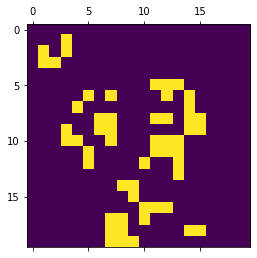

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states);
HTML(anim.to_html5_video())